# PROBLEM STATEMENT:
Here, we are particularly interested in recognizing whether two given faces are of the same person or not. Below are the steps involved in the project.

1. Load the dataset and create the metadata.
2. Check some samples of metadata.
3. Load the pre-trained model and weights.
4. Generate Embedding vectors for each face in the dataset.
5. Build distance metrics for identifying the distance between two given images.
6. Use PCA for dimensionality reduction.
7. Build SVM classifier to map each image to its right person.
8. Predict using the SVM model.

# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face recognition
Task is to recognize a faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

In [0]:
# %tensorflow_version 2.x

In [45]:
# import tensorflow
# tensorflow.__version__

#### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

#### Change current working directory to project folder (1 mark)

In [0]:
#### Add your code here ####

### Extract the zip file (2 marks)
- Extract Aligned Face Dataset from Pinterest.zip

In [196]:
#### Add your code here ####

from zipfile import ZipFile
#import datetime
import skimage.io as io
import os
#import matplotlib.pyplot as plt
#%matplotlib inline
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

file_name = "Aligned Face Dataset.zip"

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [197]:
# import numpy as np
# import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base-folder, folder-name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

# np.save('metadata.npy', metadata)

In [198]:
print(metadata.shape)
print(metadata[0].base)
print(metadata[0].name)
print(metadata[0].file)

(10770,)
PINS
pins_Aaron Paul
Aaron Paul0_262.jpg


### Define function to load image
- Define a function to load image from the metadata

In [199]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def load_image(path):
    #img = cv2.imread(path, flags=1) # flag: {1: IMREAD_COLOR, 0: IMREAD_GRAYSCALE, -1: IMREAD_UNCHANGED}
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    
    img = io.imread(path)
    img = cv2.bitwise_not(img)
    
    return img  #img[...,::-1]

#### Load a sample image (2 marks)
- Load one image using the function "load_image"

(301, 299, 3)


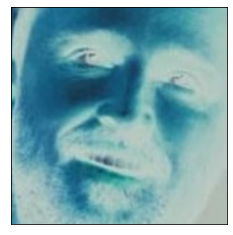

In [200]:
#### Add your code here ####

# samplePath = os.path.join(file_name, 'pins/PINS/pins_selena gomez/selena gomez4.jpg')
sampleRecord = metadata[0]
img = load_image(os.path.join(sampleRecord.base, sampleRecord.name, sampleRecord.file))

print(img.shape)

plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

# plt.figure(figsize=[10,10])
# plt.imshow(np.real(img))

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [201]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3), name="1"))
    model.add(Convolution2D(64, (3, 3), activation='relu', name="2"))
    model.add(ZeroPadding2D((1,1), name="3"))
    model.add(Convolution2D(64, (3, 3), activation='relu', name="4"))
    model.add(MaxPooling2D((2,2), strides=(2,2), name="5"))
    
    model.add(ZeroPadding2D((1,1), name="6"))
    model.add(Convolution2D(128, (3, 3), activation='relu', name="7"))
    model.add(ZeroPadding2D((1,1), name="8"))
    model.add(Convolution2D(128, (3, 3), activation='relu', name="9"))
    model.add(MaxPooling2D((2,2), strides=(2,2), name="10"))
    
    model.add(ZeroPadding2D((1,1), name="11"))
    model.add(Convolution2D(256, (3, 3), activation='relu', name="12"))
    model.add(ZeroPadding2D((1,1), name="13"))
    model.add(Convolution2D(256, (3, 3), activation='relu', name="14"))
    model.add(ZeroPadding2D((1,1), name="15"))
    model.add(Convolution2D(256, (3, 3), activation='relu', name="16"))
    model.add(MaxPooling2D((2,2), strides=(2,2), name="17"))
    
    model.add(ZeroPadding2D((1,1), name="18"))
    model.add(Convolution2D(512, (3, 3), activation='relu', name="19"))
    model.add(ZeroPadding2D((1,1), name="20"))
    model.add(Convolution2D(512, (3, 3), activation='relu', name="21"))
    model.add(ZeroPadding2D((1,1), name="22"))
    model.add(Convolution2D(512, (3, 3), activation='relu', name="23"))
    model.add(MaxPooling2D((2,2), strides=(2,2), name="24"))
    
    model.add(ZeroPadding2D((1,1), name="25"))
    model.add(Convolution2D(512, (3, 3), activation='relu', name="26"))
    model.add(ZeroPadding2D((1,1), name="27"))
    model.add(Convolution2D(512, (3, 3), activation='relu', name="28"))
    model.add(ZeroPadding2D((1,1), name="29"))
    model.add(Convolution2D(512, (3, 3), activation='relu', name="30"))
    model.add(MaxPooling2D((2,2), strides=(2,2), name="31"))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu', name="32"))
    model.add(Dropout(0.5, name="33"))
    model.add(Convolution2D(4096, (1, 1), activation='relu', name="34"))
    model.add(Dropout(0.5, name="35"))
    model.add(Convolution2D(2622, (1, 1), name="36"))
    model.add(Flatten(name="37"))
    model.add(Activation('softmax', name="38"))
    return model

#### Load the model (2 marks)
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [202]:
#model = #### Add your code here ####
#### Add your code here ####

model = vgg_face()

In [203]:
model.load_weights('vgg_face_weights.h5')

### Get vgg_face_descriptor

In [204]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [205]:
print(model.layers[0].name)  # 1
print(model.layers[-2].name)  # 37

1
37


### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [206]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images (5 marks)
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [25]:
#### Add your code here ####

emb_vec_list = []

for i in tqdm(range(metadata.shape[0])):
    # Read
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    
    # Normalize
    img = (img/255.).astype(np.float32)
    
    # Resize
    img = cv2.resize(img, dsize=(224, 224))
    
    # Predict
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    
    # Save
    emb_vec_list.append(embedding_vector)

#
np.save('embedding_vectors.npy', emb_vec_list)

100%|████████████████████████████████████████████████████████████████████████████| 10770/10770 [34:14<00:00,  5.24it/s]


### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [207]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

In [208]:
embeddings = np.load('embedding_vectors.npy', mmap_mode='r')

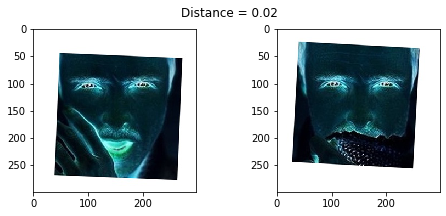

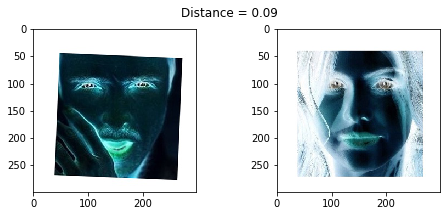

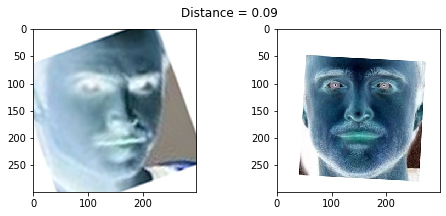

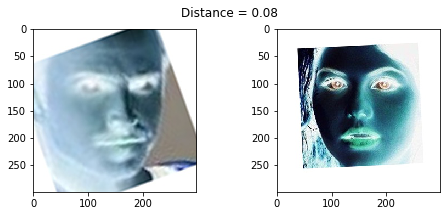

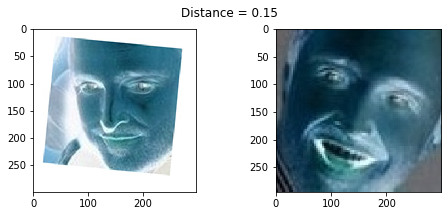

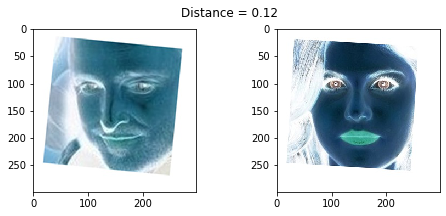

In [209]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)
show_pair(30, 31)
show_pair(30, 100)
show_pair(70, 72)
show_pair(70, 115)

### Create train and test sets (5 marks)
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [210]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

#### Add your code here ####

X_train = embeddings[train_idx]
X_test = embeddings[test_idx]

# Seperate name of each input
y = []
for i, val_i in enumerate(range(metadata.shape[0])):
    y.append(metadata[i].name)

# REFERENCE: https://www.geeksforgeeks.org/python-accessing-all-elements-at-given-list-of-indexes/
# y_train = [y[i] for i in train_idx]
# y_test = [y[i] for i in test_idx]
# y_train = list(map(y.__getitem__, train_idx))
# y_test = list(map(y.__getitem__, test_idx))

y_train = []
y_test = []
for i, val in enumerate(train_idx):
    if val:
        y_train.append(metadata[i].name)
for i, val in enumerate(test_idx):
    if val:
        y_test.append(metadata[i].name)

### Encode the Labels (3 marks)
- Encode the targets
- Use LabelEncoder

In [211]:
"""
Create list of possible labels
"""
labels_s = set()
for i in tqdm(range(metadata.shape[0])):
    entry_i = metadata[i]
    if entry_i.name not in labels_s:
        labels_s.add(entry_i.name)

#
labels_l = list(labels_s)

100%|███████████████████████████████████████████████████████████████████████| 10770/10770 [00:00<00:00, 1388816.76it/s]


In [212]:
from sklearn.preprocessing import LabelEncoder

#### Add your code here ####
le = LabelEncoder()
le.fit(labels_l)

# le.classes_
y_train_le = le.transform(y_train)
y_test_le = le.transform(y_test)

In [213]:
print(y_train_le.shape)
print(y_test_le.shape)
print(y_train_le[0])

(9573,)
(1197,)
0


### Standardize the feature values (3 marks)
- Scale the features using StandardScaler

In [215]:
"""
NORMALIZE:

All the values are all now between 0 and 1.

Normalization makes training less sensitive to the scale of features, so we can better solve for coefficients.

The use of a normalization method will improve analysis from multiple models.

Sometimes you might not want to normalize your data. 
The data provided is proportional, so normalizing might not provide correct estimators. 
r, the scale between your data features does matters so you want to keep in your dataset.


---***---

STANDARDIZE:

Output has mean of 0 and standard deviation of 1.

Compare features that have different units or scales.

When you’re running models (logistic regression, SVMs, perceptrons, neural networks etc.) 
the estimated weights will update similarly rather than at different rates during the build process. 
This will give you more accurate results when the data has been first standardized.

Standardizing tends to make the training process well behaved because the numerical condition 
of the optimization problems is improved.




"""

from sklearn.preprocessing import StandardScaler

seconds1 = time.time()

embeddings = np.load('embedding_vectors.npy', mmap_mode='r')
# Scale
scaler = StandardScaler()
scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
emb_standardized = scaler.transform(embeddings)

seconds2 = time.time()
print('Time taken: ', ((seconds2-seconds1)/60), ' minutes')

# Save
# np.save('embedding_standardized.npy', emb_standardized)

Time taken:  0.017272555828094484  minutes


### Reduce dimensions using PCA (3 marks)
- Reduce feature dimensions using Principal Component Analysis

### SAVE PCA
- https://datascience.stackexchange.com/questions/55066/how-to-export-pca-to-use-in-another-program

In [216]:
from sklearn.decomposition import PCA
import pickle as pk
import time
import numpy as np

# n_components = 0.999999  # 2420
# n_components = 0.99999  # 2137
# n_components = 0.9999  # 1677
# n_components = 0.999  # 1047
n_components = 0.99  # 366 with all records. 363 with training records.
# n_components = 0.9  # 35

#### Add your code here ####
# PCA
seconds1 = time.time()
pca = PCA(n_components=n_components).fit(X_train)
print('Number of components: ', pca.n_components_)
print('Time taken: ', ((time.time()-seconds1)/60), ' minutes')


Number of components:  363
Time taken:  0.1361021637916565  minutes


In [217]:
# # Save PCA
pk.dump(pca, open('embedding_pca_'+str(n_components)+'.pkl','wb'), protocol=4)  # protocol 4 for objects > 4 GB.
# # Load
pca = np.load('embedding_pca_'+str(n_components)+'.pkl', allow_pickle=True)

print(pca.components_.shape)

(363, 2622)


In [218]:
"""
pca.transform(faces)

# Or,

from sklearn.utils.extmath import fast_dot
td = faces - means
tdd = fast_dot(td, pca.components_.T)
"""

seconds1 = time.time()
emb_pca_transformed = pca.transform(emb_standardized)
print('Time taken: ', ((time.time()-seconds1)/60), ' minutes')

# np.save('embedding_pca_transformed.npy', emb_pca_transformed)
# emb_pca_transformed = np.load('embedding_pca_transformed.npy', mmap_mode='r')

emb_pca_transformed.shape

X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)

Time taken:  0.0035168727238972983  minutes


#### Check some distance statistics

In [24]:
# self_total_i = 0.0
# count_i = 0
# for i, val_i in enumerate(range(86)):
#     self_total_j = 0.0
#     count_j = 0
#     for j, val_j in enumerate(range(86)):
#         if i == j:
#             continue
#         count_j = count_j + 1
#         self_total_j = self_total_j + distance(emb_pca_transformed[i], emb_pca_transformed[j])
#     #print(count_j ,' Avg distance of ', i , 'is: ', (self_total_j/count_j))
#     self_total_i = self_total_i + (self_total_j/count_j)
#     count_i = count_i + 1
# self_avg = self_total_i/count_i
# print('Avg distance: ', self_avg)

# # for i, val in enumerate(range(50)):
# #     show_pair(0, ((i+1)*10))

In [25]:
# def getAvgDistanceWithSelf(self_index_in):
#     self_total_i = 0.0
#     count_i = 0
#     for i, val_i in enumerate(self_index_in):
#         self_total_j = 0.0
#         count_j = 0
#         for j, val_j in enumerate(self_index_in):
#             if i == j:
#                 continue
#             count_j = count_j + 1
#             self_total_j = self_total_j + distance(emb_pca_transformed[i], emb_pca_transformed[j])
#         #print(count_j ,' Avg distance of ', i , 'is: ', (self_total_j/count_j))
#         self_total_i = self_total_i + (self_total_j/count_j)
#         count_i = count_i + 1
#     self_avg = self_total_i/count_i
#     #print('Avg distance: ', self_avg)
#     return self_avg

In [26]:
# min_dis = 0
# max_dis = 0
# min_k = 0
# max_k = 0
# for k, val_k in enumerate(labels_s):
#     #print(k, ': ', val_k)
#     index_i = []
#     for i, val_i in enumerate(y):
#         if val_k == val_i:
#             index_i.append(i)
#     dis = round(getAvgDistanceWithSelf(index_i), 2)
#     if k == 0:
#         min_dis = dis
#         min_k = k
#     if dis < min_dis:
#         min_dis = dis
#         min_k = k
#     if dis > max_dis:
#         max_dis = dis
#         max_k = k
#     print(k, '... avg_distance: ', dis, ' ', val_k)

# print('min_dis: ', min_dis, ', k: ', min_k)
# print('max_dis: ', max_dis, ', k: ', max_k)

# # print(index_i)
# # print(len(index_i))

In [27]:
# self_total_i = 0.0
# count_i = 0
# for i, val_i in enumerate(range(86)):
#     self_total_j = 0.0
#     count_j = 0
#     for j, val_j in enumerate(range(86)):
#         if i == j:
#             continue
#         count_j = count_j + 1
#         self_total_j = self_total_j + distance(emb_pca_transformed[i], emb_pca_transformed[j])
#     #print(count_j ,' Avg distance of ', i , 'is: ', (self_total_j/count_j))
#     self_total_i = self_total_i + (self_total_j/count_j)
#     count_i = count_i + 1
# self_avg = self_total_i/count_i
# print('Avg distance: ', self_avg)

# # for i, val in enumerate(range(50)):
# #     show_pair(0, ((i+1)*10))

### Build a Classifier (3 marks)
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

REFERENCE:
- https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
- https://www.kaggle.com/pranathichunduru/svm-for-multiclass-classification

In [219]:
from sklearn.svm import SVC

#### Add your code here ####

seconds1 = time.time()

# clf = SVC(kernel='rbf') # Linear Kernel
clf = SVC(kernel='linear') # Linear Kernel
clf.fit(X_train_transformed, y_train_le)

print('Time taken: ', ((time.time()-seconds1)/60), ' minutes')

Time taken:  1.04311763048172  minutes


In [220]:
seconds1 = time.time()

y_pred = clf.predict(X_test_transformed)

print('Time taken: ', ((time.time()-seconds1)/60), ' minutes')

Time taken:  0.1758101503054301  minutes


In [221]:
"""
PRECISION vs RECALL:

REFERENCE: https://towardsdatascience.com/precision-vs-recall-386cf9f89488

NULL HYPOTHESIS: The data point belongs to population.
ALTERNATE HYPOTHESIS: The data point does not belong to population.

TYPE-1 error: Null hypothesis should be predicted. However, was not predicted.
TYPE-2 error: Alternate hypothesis should be predicted. However, was not predicted.

   
          
                 ____(N)___ACTUAL____(A)_____
P                            |
R                    TRUE    |  FALSE
E     (NULL)        POSITIVE |  POSITIVE
D                            |
I                  ----------|-------------
C                            |
T   (ALTERNATE)     FALSE    |  TRUE
E                  NEGATIVE  |  NEGATIVE
D                            |
                   ________________________


True positive: Null should be predicted. Null is predicted.
True negative: Alternate should be predicted. Alternate is predicted.
False positive: Type-1 error.
False negative: Type-2 error.

PRECISION = True positive/Actual results = True positive / (True positive + False positive)
RECALL = True positive/Predicted results = True positive / (True positive + False negative)
ACCURACY = (True positive + True negative)/Total

Precision: Out of the total prediced in this class, how many were actually of this class.
Recall: Out of the total in this class, how many were predicted in this class.
"""

from sklearn.metrics import confusion_matrix,classification_report

Y_test_label = le.inverse_transform(y_test_le)
Y_pred_label = le.inverse_transform(y_pred)

print(confusion_matrix(Y_test_label,Y_pred_label))
print("\n")
print(classification_report(Y_test_label,Y_pred_label))

[[4 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 7 ... 0 0 0]
 ...
 [0 0 0 ... 4 1 1]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 5]]


                               precision    recall  f1-score   support

              pins_Aaron Paul       0.24      0.40      0.30        10
            pins_Alvaro Morte       0.33      0.20      0.25        10
             pins_Amanda Crew       0.70      0.50      0.58        14
          pins_Amaury Nolasco       0.56      0.75      0.64        12
               pins_Anna Gunn       0.71      0.71      0.71         7
    pins_Benedict Cumberbatch       0.44      0.44      0.44         9
            pins_Betsy Brandt       0.22      0.29      0.25         7
        pins_Brenton Thwaites       0.37      0.50      0.42        14
            pins_Brit Marling       0.28      0.36      0.31        14
          pins_Bryan Cranston       0.58      0.78      0.67         9
              pins_Caity Lotz       0.33      0.50      0.40        14
        pins_Cameron Mona

### Hyperparameter tuning
- https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

In [222]:
from zipfile import ZipFile
import skimage.io as io
import os
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

from sklearn.decomposition import PCA
import pickle as pk
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [223]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base-folder, folder-name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

# np.save('metadata.npy', metadata)

In [239]:
from sklearn.preprocessing import StandardScaler

embeddings = np.load('embedding_vectors.npy', mmap_mode='r')

In [251]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

X_train = embeddings[train_idx]
X_test = embeddings[test_idx]

"""
Scale on training data only, as test data is replacement for prod data which is not available for training
"""
# Scale
scaler = StandardScaler()
emb_standardized = scaler.fit(X_train)  # fit to find mean and standardDeviation for standardizing

# Standardize
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Seperate name of each input
y = []
for i, val_i in enumerate(range(metadata.shape[0])):
    y.append(metadata[i].name)

y_train = []
y_test = []
for i, val in enumerate(train_idx):
    if val:
        y_train.append(metadata[i].name)
for i, val in enumerate(test_idx):
    if val:
        y_test.append(metadata[i].name)

In [252]:
"""
Create list of possible labels
"""
labels_s = set()
for i in (range(metadata.shape[0])):
    entry_i = metadata[i]
    if entry_i.name not in labels_s:
        labels_s.add(entry_i.name)

labels_l = list(labels_s)

#
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(labels_l)

y_train_le = le.transform(y_train)
y_test_le = le.transform(y_test)

In [253]:
c_list = []
gamma_list = []
kernel_list = []
infoKept_list = []
features_list = []
score_list = []
rank_list = []



def parseParams(grid_in, infoKept, pca_n_components, infoKept_list_in, features_list_in, 
                c_list_in, gamma_list_in, kernel_list_in, score_list_in, rank_list_in):
    res_params = grid_in.cv_results_['params']
    for i, param in enumerate(res_params):
        infoKept_list_in.append(infoKept)
        features_list_in.append(pca_n_components)
        c_list_in.append(param['C'])
        gamma_list_in.append(param['gamma'])
        kernel_list_in.append(param['kernel'])
        score_list_in.append(round(grid_in.cv_results_['mean_test_score'][i], 5))
        rank_list_in.append(grid_in.cv_results_['rank_test_score'][i])

#
def saveGridSearchCv(filname_in):
    res_params_df = pd.DataFrame({'c': c_list, 'gamma': gamma_list, 'kernel': kernel_list,
                                  'infoKept': infoKept_list, 'noOfFeatures': features_list,
                                  'score': score_list, 'rank': rank_list})
    res_params_df.to_csv(filname_in, index=False)


In [256]:
"""
Define function to run a grid configuration 
"""

def processGrid(n_components, param_grid, verbose_in=3, 
                filename_in='gridSearchCv_performanceMatrix_xStandardized_v1.csv'):
    print('')
    print('***')
    seconds1 = time.time()
    
    print('n_components: ', n_components)
    seconds1 = time.time()
    pca = PCA(n_components=n_components).fit(X_train)
    print('Number of components: ', pca.n_components_)
    X_train_transformed = pca.transform(X_train)
    X_test_transformed = pca.transform(X_test)
    
    #param_grid = {'C': [3500, 2500],
    #              'gamma': [150, 100, 50, 10, 5, 2, 1, 0.5, 0.25, 0.1, 0.01],
    #              'kernel': ['rbf', 'linear']}
    
    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = verbose_in)
    grid.fit(X_train_transformed, y_train_le)
    
    # print best parameter after tuning 
    print(grid.best_params_) 
    print('Max score: ', max(grid.cv_results_['mean_test_score']))
    # All scores
    print(grid.cv_results_['mean_test_score'])
    # Add scores to lists
    parseParams(grid, n_components, pca.n_components_, 
                infoKept_list, features_list, c_list, gamma_list, 
                kernel_list, score_list, rank_list)
    saveGridSearchCv(filename_in)
    
    print('Time taken: ', ((time.time()-seconds1)/60), ' minutes')

In [257]:
n_components_list = [0.99]


param_grid_list = [
                    {'C': [8000, 5000, 3000, 1000, 500, 100, 10, 5, 2, 1, 0.5, 0.1, 0.01],
                    'gamma': [1e-05],
                    'kernel': ['rbf']},
    
                    {'C': [10000],
                    'gamma': [0, 1e-8, 5e-8, 1e-7, 5e-7, 
                             0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 1],
                    'kernel': ['rbf']},
    
                   {'C': [10000, 8000, 6000, 50000, 3500, 3000, 2500, 2000, 1000, 100, 10, 5],
                   'gamma': [150],
                   'kernel': ['linear']},
    
                   {'C': [1, 0.5, 0.1, 0.01],
                   'gamma': [150, 50, 10, 5, 1],
                   'kernel': ['linear']}
                  ]

# Loop through the values
for i, param_grid_i in enumerate(param_grid_list):
    for j, n_components_j in enumerate(n_components_list):
        processGrid(n_components, param_grid_i, verbose_in=3, 
                    filename_in='gridSearchCv_performanceMatrix_xStandardized_v3.csv')


***
n_components:  0.99
Number of components:  363
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=8000, gamma=1e-05, kernel=rbf .................................
[CV] ..... C=8000, gamma=1e-05, kernel=rbf, score=0.393, total=  57.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.7s remaining:    0.0s


[CV] C=8000, gamma=1e-05, kernel=rbf .................................
[CV] ..... C=8000, gamma=1e-05, kernel=rbf, score=0.381, total=  57.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] C=8000, gamma=1e-05, kernel=rbf .................................
[CV] ..... C=8000, gamma=1e-05, kernel=rbf, score=0.381, total=  57.5s
[CV] C=5000, gamma=1e-05, kernel=rbf .................................
[CV] ..... C=5000, gamma=1e-05, kernel=rbf, score=0.393, total=  58.1s
[CV] C=5000, gamma=1e-05, kernel=rbf .................................
[CV] ..... C=5000, gamma=1e-05, kernel=rbf, score=0.381, total=  57.1s
[CV] C=5000, gamma=1e-05, kernel=rbf .................................
[CV] ..... C=5000, gamma=1e-05, kernel=rbf, score=0.381, total=  56.6s
[CV] C=3000, gamma=1e-05, kernel=rbf .................................
[CV] ..... C=3000, gamma=1e-05, kernel=rbf, score=0.394, total=  56.9s
[CV] C=3000, gamma=1e-05, kernel=rbf .................................
[CV] ..... C=3000, gamma=1e-05, kernel=rbf, score=0.380, total=  57.8s
[CV] C=3000, gamma=1e-05, kernel=rbf .................................
[CV] ..... C=3000, gamma=1e-05, kernel=rbf, score=0.381, total=  55.6s
[CV] C

[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 50.3min finished


{'C': 8000, 'gamma': 1e-05, 'kernel': 'rbf'}
Max score:  0.3851457223440928
[0.38514572 0.38504126 0.38504126 0.38148961 0.38107176 0.36853651
 0.27514886 0.22333647 0.1323514  0.07761412 0.03603886 0.01681813
 0.01681813]
Time taken:  51.715184621016185  minutes

***
n_components:  0.99
Number of components:  363
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=10000, gamma=0, kernel=rbf ....................................
[CV] ........ C=10000, gamma=0, kernel=rbf, score=0.017, total= 2.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV] C=10000, gamma=0, kernel=rbf ....................................
[CV] ........ C=10000, gamma=0, kernel=rbf, score=0.017, total= 1.8min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


[CV] C=10000, gamma=0, kernel=rbf ....................................
[CV] ........ C=10000, gamma=0, kernel=rbf, score=0.017, total= 1.9min
[CV] C=10000, gamma=1e-08, kernel=rbf ................................
[CV] .... C=10000, gamma=1e-08, kernel=rbf, score=0.264, total= 1.5min
[CV] C=10000, gamma=1e-08, kernel=rbf ................................
[CV] .... C=10000, gamma=1e-08, kernel=rbf, score=0.281, total= 1.6min
[CV] C=10000, gamma=1e-08, kernel=rbf ................................
[CV] .... C=10000, gamma=1e-08, kernel=rbf, score=0.277, total= 1.4min
[CV] C=10000, gamma=5e-08, kernel=rbf ................................
[CV] .... C=10000, gamma=5e-08, kernel=rbf, score=0.345, total= 1.2min
[CV] C=10000, gamma=5e-08, kernel=rbf ................................
[CV] .... C=10000, gamma=5e-08, kernel=rbf, score=0.353, total= 1.2min
[CV] C=10000, gamma=5e-08, kernel=rbf ................................
[CV] .... C=10000, gamma=5e-08, kernel=rbf, score=0.351, total= 1.2min
[CV] C

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 79.0min finished


{'C': 10000, 'gamma': 1e-05, 'kernel': 'rbf'}
Max score:  0.3851457223440928
[0.01681813 0.27368641 0.34983809 0.365925   0.37835579 0.38107176
 0.3838922  0.38514572 0.3838922  0.38128069 0.35150945 0.30920297
 0.0628852  0.02715972 0.01859396 0.01754936]
Time taken:  80.59664940039316  minutes

***
n_components:  0.99
Number of components:  363
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=10000, gamma=150, kernel=linear ...............................
[CV] ... C=10000, gamma=150, kernel=linear, score=0.385, total= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] C=10000, gamma=150, kernel=linear ...............................
[CV] ... C=10000, gamma=150, kernel=linear, score=0.383, total= 1.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV] C=10000, gamma=150, kernel=linear ...............................
[CV] ... C=10000, gamma=150, kernel=linear, score=0.377, total= 1.1min
[CV] C=8000, gamma=150, kernel=linear ................................
[CV] .... C=8000, gamma=150, kernel=linear, score=0.385, total= 1.2min
[CV] C=8000, gamma=150, kernel=linear ................................
[CV] .... C=8000, gamma=150, kernel=linear, score=0.383, total= 1.1min
[CV] C=8000, gamma=150, kernel=linear ................................
[CV] .... C=8000, gamma=150, kernel=linear, score=0.377, total= 1.1min
[CV] C=6000, gamma=150, kernel=linear ................................
[CV] .... C=6000, gamma=150, kernel=linear, score=0.385, total= 1.1min
[CV] C=6000, gamma=150, kernel=linear ................................
[CV] .... C=6000, gamma=150, kernel=linear, score=0.383, total= 1.1min
[CV] C=6000, gamma=150, kernel=linear ................................
[CV] .... C=6000, gamma=150, kernel=linear, score=0.377, total= 1.1min
[CV] C

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 40.5min finished


{'C': 10000, 'gamma': 150, 'kernel': 'linear'}
Max score:  0.3819074480309203
[0.38190745 0.38190745 0.38190745 0.38190745 0.38190745 0.38190745
 0.38190745 0.38190745 0.38190745 0.38190745 0.38190745 0.38190745]
Time taken:  41.90938332080841  minutes

***
n_components:  0.99
Number of components:  363
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=1, gamma=150, kernel=linear ...................................
[CV] ....... C=1, gamma=150, kernel=linear, score=0.385, total= 1.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV] C=1, gamma=150, kernel=linear ...................................
[CV] ....... C=1, gamma=150, kernel=linear, score=0.383, total= 1.0min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV] C=1, gamma=150, kernel=linear ...................................
[CV] ....... C=1, gamma=150, kernel=linear, score=0.377, total= 1.0min
[CV] C=1, gamma=50, kernel=linear ....................................
[CV] ........ C=1, gamma=50, kernel=linear, score=0.385, total= 1.0min
[CV] C=1, gamma=50, kernel=linear ....................................
[CV] ........ C=1, gamma=50, kernel=linear, score=0.383, total=  57.8s
[CV] C=1, gamma=50, kernel=linear ....................................
[CV] ........ C=1, gamma=50, kernel=linear, score=0.377, total= 1.0min
[CV] C=1, gamma=10, kernel=linear ....................................
[CV] ........ C=1, gamma=10, kernel=linear, score=0.385, total= 1.0min
[CV] C=1, gamma=10, kernel=linear ....................................
[CV] ........ C=1, gamma=10, kernel=linear, score=0.383, total= 1.0min
[CV] C=1, gamma=10, kernel=linear ....................................
[CV] ........ C=1, gamma=10, kernel=linear, score=0.377, total=  53.5s
[CV] C

[CV] ...... C=0.01, gamma=1, kernel=linear, score=0.378, total=  52.5s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 54.3min finished


{'C': 0.1, 'gamma': 150, 'kernel': 'linear'}
Max score:  0.382220829416066
[0.38190745 0.38190745 0.38190745 0.38190745 0.38190745 0.38190745
 0.38190745 0.38190745 0.38190745 0.38190745 0.38222083 0.38222083
 0.38222083 0.38222083 0.38222083 0.37856471 0.37856471 0.37856471
 0.37856471 0.37856471]
Time taken:  55.439213236172996  minutes


## OBSERVATIONS FROM HYPERTUNING:

### Without standardizing

- rbf:
    - For constant C (10000), score of this model seems to be increasing when the gamma is reduced (150...5)
    - Time taken by rbf is very high compared to linear
    - Performance reduced from gamma 200 to 10

- linear:
    - For constant C (10000), score of this model seems to be unaffected by gamma (150...5)
    - Performance peaked for C between 4500 and 1500, and gamma 150
    - Performance reduced from below C 1500

- rbf and linear:
    - Same behavior at C values (10000...4500)

- Next:
    - rbf with gamma < 5 at C 10000

- Best combination found so far:
    - {'C': 3500, 'gamma': 150, 'kernel': 'linear'}



### With standardizing

- rbf:
    - Performance is high at low gamma with constant C (10000). Tried gamma of 0.001 to 150.
    - Performance is low at gamma = 0

- linear:

- rbf and linear:

- Next:
    - rbf with gamma < 0.001 at C 10000
    - At the best gamma range, hypertune C

- Best combination found so far:

{'C': 10000, 'gamma': 1e-05, 'kernel': 'rbf'}
Max score:  0.3851457223440928

{'C': 0.1, 'gamma': 150, 'kernel': 'linear'}
Max score:  0.382220829416066

### Build classifier with the identified parameters

In [258]:
n_components = 0.99

pca = PCA(n_components=n_components).fit(X_train)
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)

# Use the identified parameters to initialize the classifier
clf = SVC(C=10000, gamma=1e-05, kernel='rbf')
# clf = SVC(C=0.1, gamma=150, kernel='linear')
clf.fit(X_train_transformed, y_train_le)

y_pred = clf.predict(X_test_transformed)

In [259]:
from sklearn.metrics import confusion_matrix,classification_report

Y_test_label = le.inverse_transform(y_test_le)
Y_pred_label = le.inverse_transform(y_pred)

print(confusion_matrix(Y_test_label,Y_pred_label))
print("\n")
print(classification_report(Y_test_label,Y_pred_label))

[[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 4 1 1]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 5]]


                               precision    recall  f1-score   support

              pins_Aaron Paul       0.29      0.50      0.37        10
            pins_Alvaro Morte       0.67      0.40      0.50        10
             pins_Amanda Crew       0.55      0.43      0.48        14
          pins_Amaury Nolasco       0.60      0.75      0.67        12
               pins_Anna Gunn       0.83      0.71      0.77         7
    pins_Benedict Cumberbatch       0.50      0.44      0.47         9
            pins_Betsy Brandt       0.25      0.29      0.27         7
        pins_Brenton Thwaites       0.27      0.43      0.33        14
            pins_Brit Marling       0.30      0.43      0.35        14
          pins_Bryan Cranston       0.58      0.78      0.67         9
              pins_Caity Lotz       0.37      0.50      0.42        14
        pins_Cameron Mona

### Test results (1 mark)
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

In [241]:
def predictName(img_in, scaler_in, pca_in, clf_in, le_in):
    # Normalising
    img_in = (img_in / 255.).astype(np.float32)
    # Reshape
    img_in = cv2.resize(img_in, dsize = (224,224))
    #Encode
    img_in = [vgg_face_descriptor.predict(np.expand_dims(img_in, axis=0))[0]]
    # Scale
    img_in = scaler_in.transform(img_in)
    # PCA
    img_in = pca_in.transform(img_in)
    # Predict
    y_pred_in = clf_in.predict(img_in)
    
    return  y_pred_in

Image path:  PINS\pins_alexandra daddario\alexandra daddario101.jpg


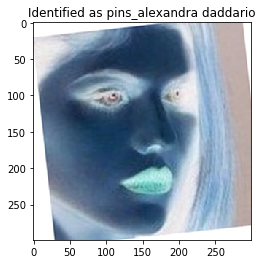

In [247]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10
print('Image path: ', metadata[test_idx][example_idx].image_path())
example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = predictName(example_image, scaler, pca, clf, le)
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

### ...

# EXTRAS...not part of the solution
- https://medium.com/@sebastiannorena/pca-principal-components-analysis-applied-to-images-of-faces-d2fc2c083371
- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

## https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [170]:
pip install colormap

  Created wheel for colormap: filename=colormap-1.0.3-cp37-none-any.whl size=15569 sha256=0450f3af1d90870492d9f7b0a6ff38a3aefab597a0495e5d03e285f67d5e08f7
  Stored in directory: C:\Users\Ravi Yadav\AppData\Local\pip\Cache\wheels\b5\c4\23\5f5d3e77fb0d00f44ee147a9cbb3acb641b9ebe2f3d5406c66
Successfully built colormap
Note: you may need to restart the kernel to use updated packages.


In [264]:
from sklearn.decomposition import PCA

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# import colormap as cmaps
# from colormap import Colormap
# c = Colormap()
# plt.register_cmap(name='spectral', cmap=cmaps.spectral)

In [165]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [166]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


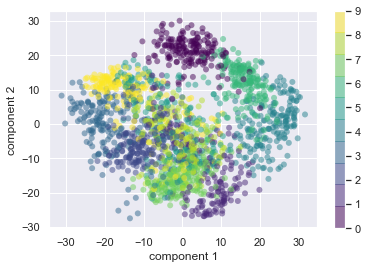

In [174]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

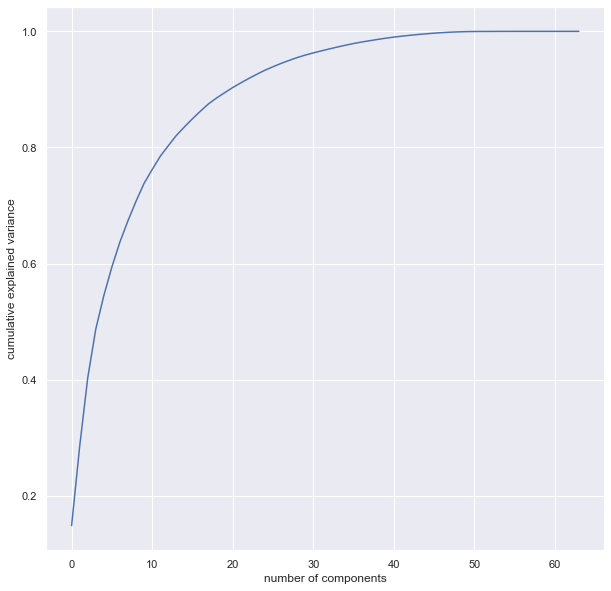

In [178]:
pca = PCA().fit(digits.data)

plt.figure(figsize=[10,10])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## PCA for Noice Filtering
- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

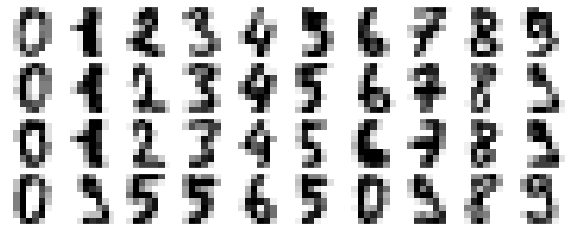

In [225]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
    plt.show()
plot_digits(digits.data)

(1797, 64)


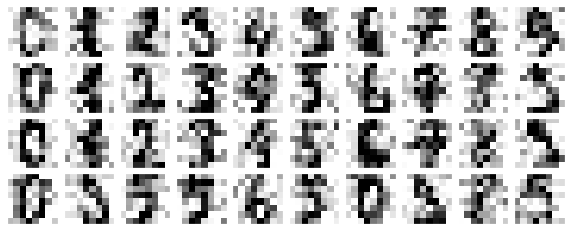

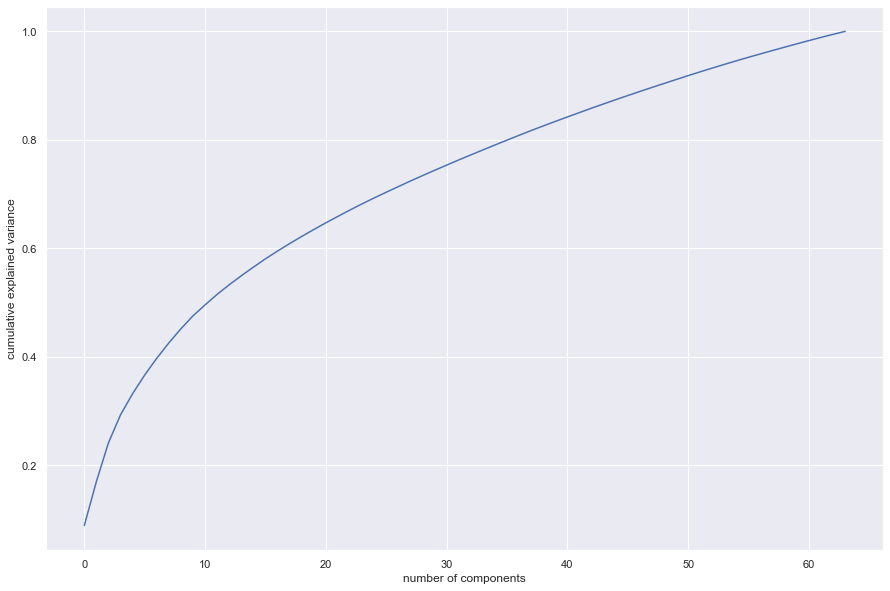

In [259]:
# Add noise
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
print(noisy.shape)
plot_digits(noisy)

# PCA on noisy data
pca = PCA().fit(noisy)

plt.figure(figsize=[15,10])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Number of components:  12


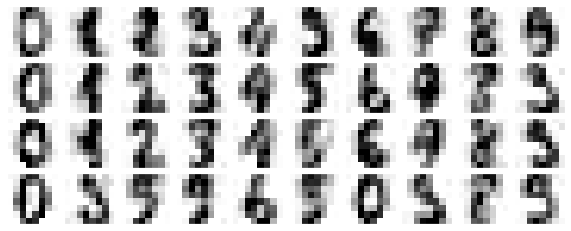

In [260]:
pca = PCA(0.50).fit(noisy)
print('Number of components: ', pca.n_components_)

components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

## https://medium.com/@sebastiannorena/pca-principal-components-analysis-applied-to-images-of-faces-d2fc2c083371

In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns; sns.set()
import time

In [2]:
import numpy as np

# Flattened faces
faces = np.load('images_resized_train_flattened.npy', mmap_mode='r')  # 6332761  = 6.03 GB
print(faces[0].shape)
faces[0]

# faces_flattened = []
# for face_i in tqdm(faces):
#     faces_flattened.append(face_i.flatten())

# #
# np.save('faces_flattened_train.npy', X_train)  # 98049  = 95.7 MB

(150528,)


memmap([ 0.827451  ,  0.47450984,  0.2941177 , ..., -0.38823527,
        -0.4823529 , -0.40392154], dtype=float32)

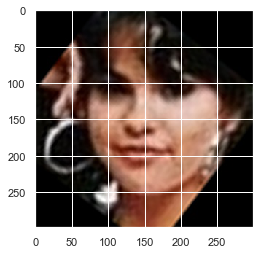

In [261]:
#import numpy as np
#from scipy.misc import imread
#import matplotlib.pyplot as plt

samplePath = os.path.join(file_name, 'pins/PINS/pins_selena gomez/selena gomez4.jpg')
# img = load_image(samplePath)
# plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# plt.show()

# img=io.imread(samplePath, as_gray=True)
# img = cv2.resize(img, dsize=(112, 92))

img = io.imread(samplePath)
img = img.astype(np.uint8)
img = img / 255
plt.imshow(img,cmap='gray')

In [298]:
# #from glob import iglob
# #faces = pd.DataFrame([])

# faces = []

# rootPath = 'D:\\workingDirectory\\PROJECTS\\16 - PROJECT - R10 - 02 - Advanced Computer Vision\\PCA test images\\test images'
# path_list_temp = ['Aaron Paul0_262.jpg', 'alexandra daddario0.jpg', 'Alvaro Morte1_799.jpg', 
#                   'alycia debnam carey face1.jpg', 'Amanda Crew0.jpg', 'Amaury Nolasco0.jpg', 
#                  'amber heard face0.jpg', 'Anna Gunn3_2291.jpg', 'anne hathaway0.jpg', 'barbara palvin face0.jpg', 
#                  'bellamy blake face0.jpg', 'Benedict Cumberbatch0.jpg', 'Betsy Brandt1_407.jpg', 
#                  'bill gates0.jpg', 'Brenton Thwaites0.jpg', 'brie larson0.jpg', 'Brit Marling1_499.jpg']

# # for path in iglob('PCA test images/*.jpg'):
# for j, val in enumerate(path_list_temp):
#     path = os.path.join(rootPath, val)
#     img=io.imread(path, as_gray=False)
#     img = cv2.resize(img, dsize=(224, 224))
#     #print(img.shape)
#     #face = pd.Series(img.flatten(),name=path)
#     #faces = faces.append(face)
#     faces.append(img.flatten())
    
# # fig, axes = plt.subplots(1,5,figsize=(9,9),
# #                      subplot_kw={'xticks':[], 'yticks':[]},
# #                      gridspec_kw=dict(hspace=0.01, wspace=0.01))
# # for i, ax in enumerate(axes.flat):
# #     ax.imshow(faces.iloc[i].values.reshape(112,92),cmap='gray')

# """

# ValueError: Colormap grey is not recognized. 
# Possible values are: 
#  Accent, Accent_r, 
#  Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, 
#  CMRmap, CMRmap_r, 
#  Dark2, Dark2_r, 
#  GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, 
#  OrRd, OrRd_r, Oranges, Oranges_r, 
#  PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, 
#  PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, 
#  RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, 
#  Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, 
#  Wistia, Wistia_r, 
#  YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, 
#  afmhot, afmhot_r, autumn, autumn_r, 
#  binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, 
#  cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, 
#  flag, flag_r, 
#  gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, 
#  gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, 
#  gnuplot2_r, gnuplot_r, gray, gray_r, 
#  hot, hot_r, hsv, hsv_r, 
#  icefire, icefire_r, inferno, inferno_r, 
#  jet, jet_r, 
#  magma, magma_r, mako, mako_r, 
#  nipy_spectral, nipy_spectral_r, 
#  ocean, ocean_r, 
#  pink, pink_r, plasma, plasma_r, prism, prism_r, 
#  rainbow, rainbow_r, rocket, rocket_r, 
#  seismic, seismic_r, spring, spring_r, summer, summer_r, 
#  tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, 
#  twilight, twilight_r, twilight_shifted, twilight_shifted_r, 
#  viridis, viridis_r, vlag, vlag_r, 
#  winter, winter_r

# """

'\n\nValueError: Colormap grey is not recognized. \nPossible values are: \n Accent, Accent_r, \n Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, \n CMRmap, CMRmap_r, \n Dark2, Dark2_r, \n GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, \n OrRd, OrRd_r, Oranges, Oranges_r, \n PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, \n PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, \n RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, \n Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, \n Wistia, Wistia_r, \n YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, \n afmhot, afmhot_r, autumn, autumn_r, \n binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, \n cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, \n flag, flag_r, \n gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

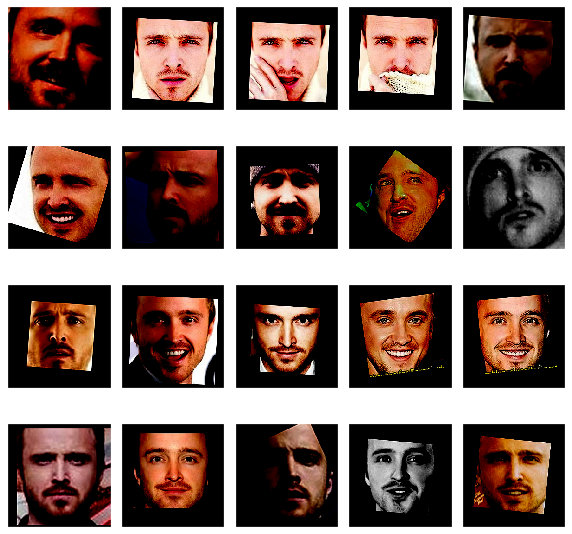

(150528,)


In [6]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 5, figsize=(10, 10),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        if i >= len(data):
            return
        ax.imshow(data[i].reshape(224, 224, 3),
                  cmap='Accent', interpolation='nearest',
                  clim=(0, 16))
        # cmap='binary'
        
    plt.show()
plot_digits(faces)
print(faces[0].shape)

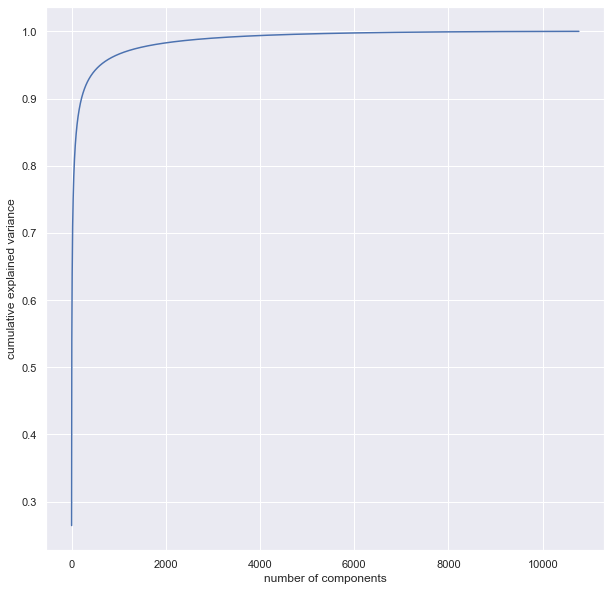

In [7]:
pca = PCA().fit(faces)

plt.figure(figsize=[10,25])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [3]:
# plt.figure(figsize=[15,15])
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [3]:
seconds1 = time.time()

# n_components, if less than 1, is the variance to keep. Else, it is the number of components to keep.
# It cannot be more than min(image_size, number_of_images)

# pca = PCA(n_components=0.999999).fit(faces)  # 10736 features
# pca = PCA(n_components=0.99999).fit(faces)  # 10610 features
# pca = PCA(n_components=0.9999).fit(faces)  # ??? features
pca = PCA(n_components=0.999).fit(faces)  # 7521 features
# pca = PCA(n_components=0.99).fit(faces)  # ??? features
# pca = PCA(n_components=0.9).fit(faces)  # 211 features

print('Number of components: ', pca.n_components_)

seconds2 = time.time()
print('Time taken: ', ((seconds2-seconds1)/60), ' minutes')
# components = pca.transform(faces)
# filtered = pca.inverse_transform(components)
# plot_digits(filtered)

Number of components:  7521
Time taken:  24.419857943058012  minutes


In [279]:
from sklearn.decomposition import PCA
#n_components=0.80 means it will return the Eigenvectors that have the 80% of the variation in the dataset
faces_pca = PCA(n_components=0.8)
faces_pca.fit(faces)

print(len(faces))

fig, axes = plt.subplots(1,5,figsize=(9,9),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.01, wspace=0.01))
#print(len(axes.flat))
for i, ax in enumerate(axes.flat):
    if i >= len(faces):
            break
    #ax.imshow(faces_pca.components_[i].reshape(112,92),cmap='gray')
    plt.imshow(faces_pca.components_[i].reshape(112,92),cmap='gray')
    plt.show()

ValueError: Found array with dim 3. Estimator expected <= 2.

## Flatten

In [6]:
import numpy as np
from tqdm import tqdm

# type(faces)  # numpy.memmap
# type(faces[0])

In [ ]:
# Flattened faces
faces = np.load('images_resized_train_flattened.npy', mmap_mode='r')  # 6332761  = 6.03 GB
#print(faces[0].shape)

faces_flattened = []

i = 0
for face_i in tqdm(faces):
    i = i + 1
    #print(face_i.shape)
    #face_i_flat = face_i.flatten()
    #print(face_i_flat.shape)  # 150528
    faces_flattened.append(face_i.flatten())
    if i >= 10:
        break

#
print(faces_flattened[0].shape)

# np.save('faces_flattened_train_2.npy', faces_flattened)

In [10]:
faces = np.load('images_resized_train_flattened.npy', mmap_mode='r')  # 6332761  = 6.03 GB

print(faces[9].shape)

(150528,)
